In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import bartz
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
from stochtree import BARTModel
import time

## Triazines

In [2]:
from sklearn.datasets import fetch_openml

# Triazines dataset from UCI
triazines = fetch_openml(name='triazines', version=1, as_frame=True)
X = triazines.data
y = triazines.target

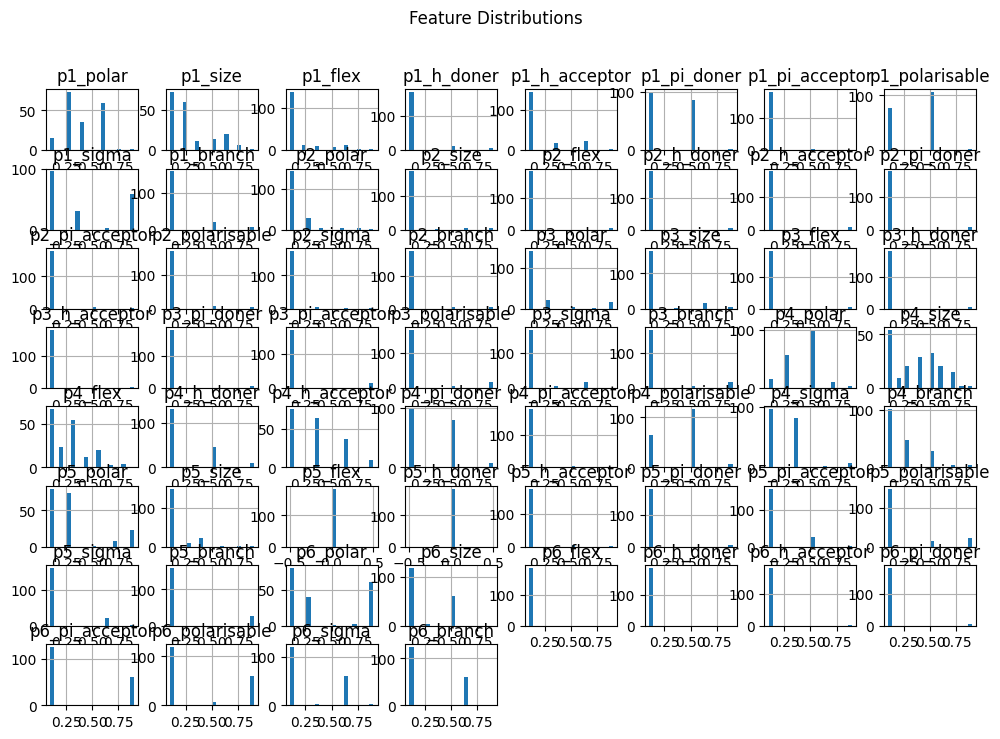

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

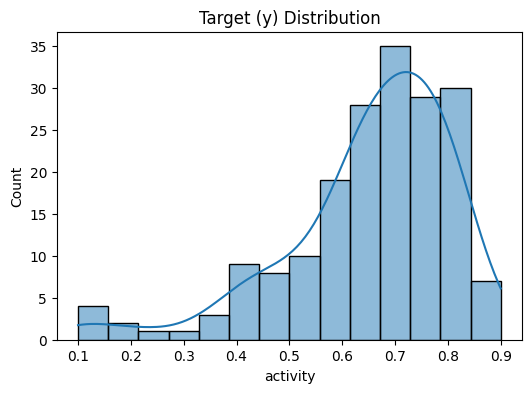

In [4]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

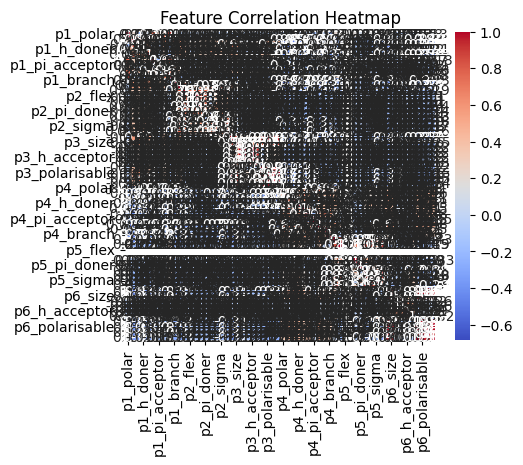

In [5]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [7]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.015085                 1.008128             1.007178   
1                  1.005806                 1.000228             1.006761   
2                  1.007002                 1.006653             1.002520   
3                  1.001194                 1.023599             1.001494   
4                  1.003999                 1.004763             1.002415   
mean               1.006617                 1.008674             1.004074   
std                0.005215                 0.008857             0.002678   

      DefaultBART_Rhat_RMSE  
0                  1.008709  
1                  1.005359  
2                  1.007352  
3                  1.003872  
4                  1.001083  
mean               1.005275  
std                0.002985  


In [8]:
rhat_df.to_csv("results/real8_Triazines_rhat.csv", index=False)

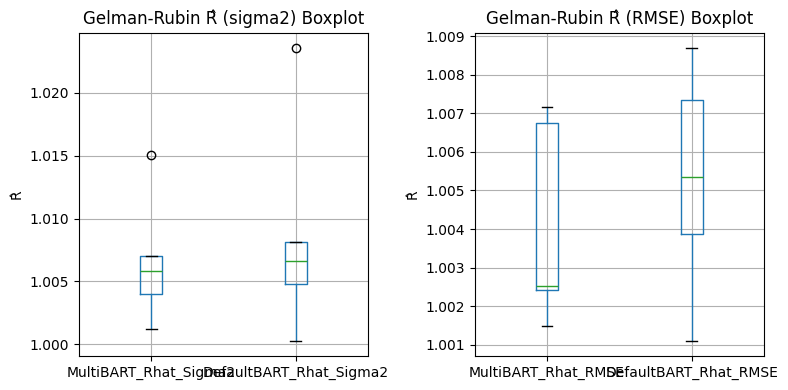

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

INFO:2025-10-30 00:49:54,448:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-10-30 00:49:57,243:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-10-30 00:50:01,376:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to op

test_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.020329  0.020129  0.020500  0.020100  0.022165
1      0.015932  0.015676  0.016704  0.010456  0.008847
2      0.015583  0.015547  0.016166  0.015804  0.022521
3      0.015063  0.015109  0.015372  0.019007  0.027133
4      0.014402  0.014172  0.014538  0.016437  0.018578
5      0.024185  0.024118  0.026063  0.019980  0.023882
6      0.012724  0.012944  0.012565  0.019972  0.022427
7      0.018531  0.018203  0.019039  0.017551  0.017660
8      0.011217  0.011093  0.011470  0.007863  0.010011
9      0.009820  0.009608  0.010183  0.009424  0.013731
mean   0.015779  0.015660  0.016260  0.015659  0.018695
std    0.004308  0.004287  0.004706  0.004704  0.006118



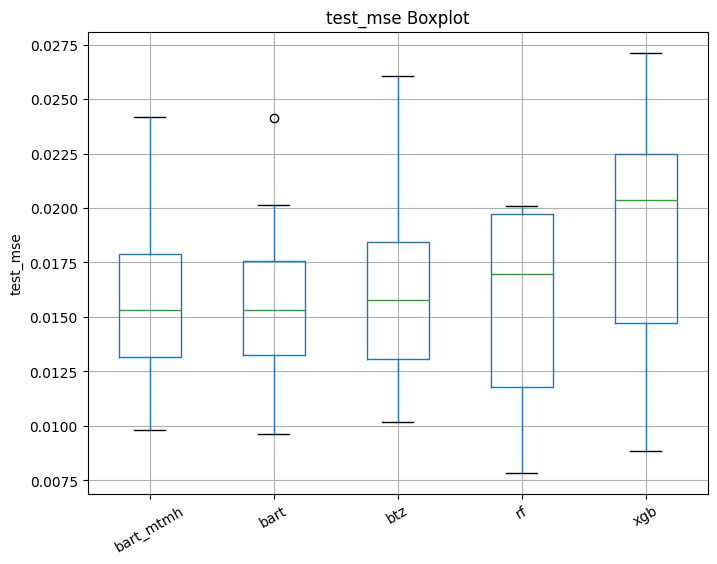

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.011509  0.010566  0.011298  0.001889  0.000017
1      0.014052  0.013209  0.014471  0.002761  0.000335
2      0.012784  0.012057  0.013332  0.002411  0.000320
3      0.013534  0.012718  0.013760  0.001884  0.000047
4      0.014677  0.013848  0.014092  0.002145  0.000333
5      0.011109  0.010635  0.012255  0.002086  0.000362
6      0.013780  0.012532  0.014201  0.001827  0.000055
7      0.011729  0.011090  0.012210  0.002243  0.000323
8      0.015714  0.015301  0.015769  0.003117  0.000359
9      0.015750  0.014717  0.015293  0.002526  0.000072
mean   0.013464  0.012667  0.013668  0.002289  0.000222
std    0.001668  0.001641  0.001415  0.000419  0.000151



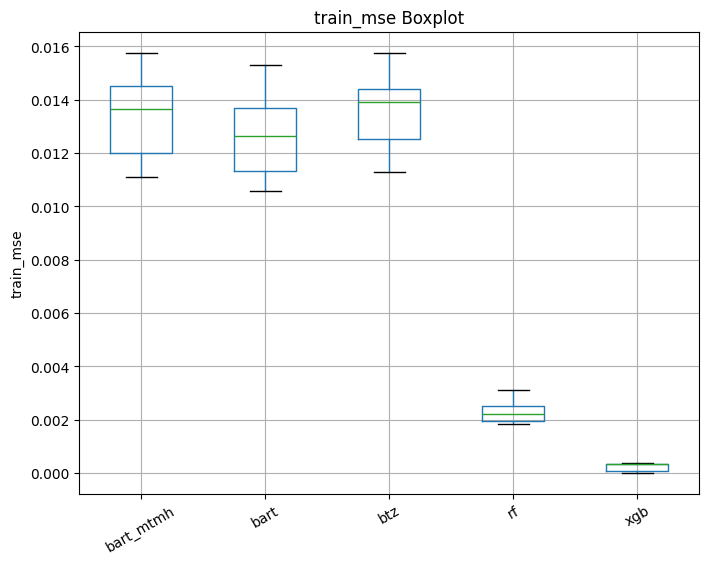

pi_length:
      bart_mtmh      bart       btz
0      0.496486  0.486717  0.488582
1      0.551254  0.540482  0.542865
2      0.516642  0.514724  0.518087
3      0.540570  0.533769  0.532361
4      0.553747  0.556891  0.536266
5      0.494992  0.488948  0.495946
6      0.538810  0.526673  0.538267
7      0.506140  0.504871  0.513562
8      0.567456  0.571483  0.566057
9      0.576133  0.575119  0.564693
mean   0.534223  0.529968  0.529669
std    0.029163  0.031690  0.025967



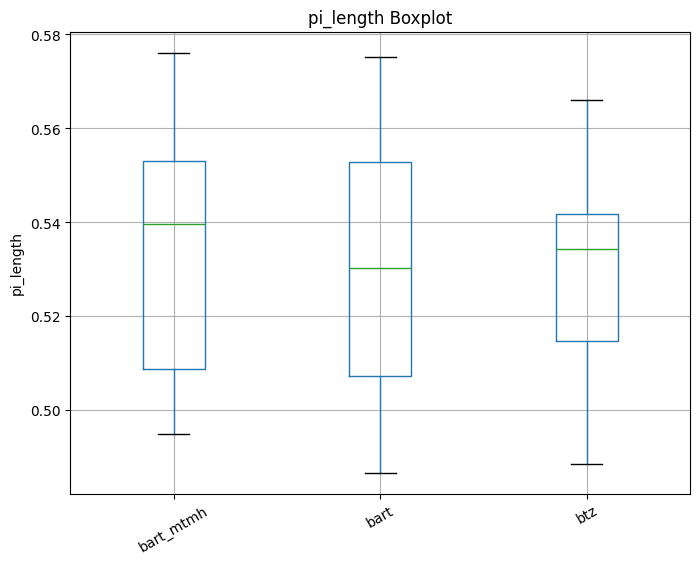

coverage:
      bart_mtmh      bart       btz
0      0.893617  0.914894  0.893617
1      0.936170  0.936170  0.936170
2      0.957447  0.957447  0.957447
3      0.914894  0.914894  0.914894
4      0.978723  0.957447  0.978723
5      0.914894  0.914894  0.893617
6      0.978723  0.978723  0.978723
7      0.936170  0.936170  0.936170
8      0.978723  0.978723  0.978723
9      1.000000  1.000000  0.978723
mean   0.948936  0.948936  0.944681
std    0.035033  0.030422  0.035033



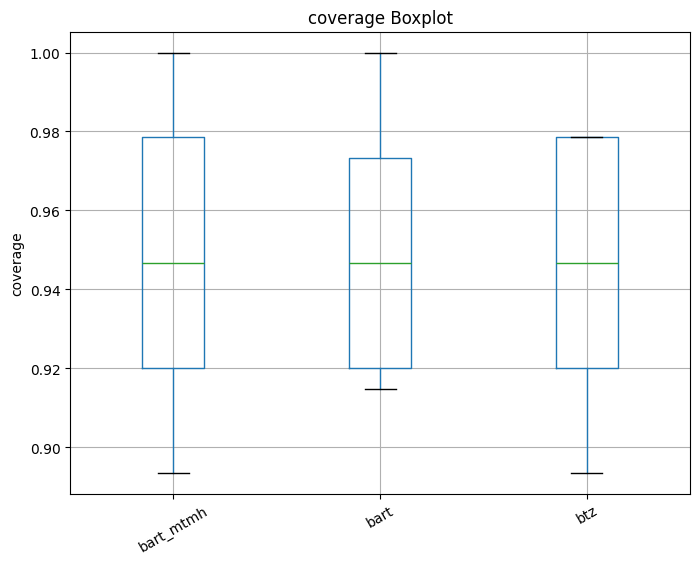

train_time:
      bart_mtmh       bart        btz        rf       xgb
0     60.951131  16.664973  16.876307  0.224750  0.113523
1     62.302992  17.652016  16.912795  0.202060  0.099345
2     63.800436  17.722080  17.019239  0.206645  0.111139
3     56.218201  14.334043  16.103717  0.200740  0.372607
4     58.857943  14.623813  16.488334  0.234370  0.119853
5     62.959653  14.726337  15.915310  0.225884  0.125190
6     58.697763  14.573052  16.864743  0.210574  0.111526
7     65.914864  14.614353  16.685955  0.214717  0.120251
8     60.770020  19.207805  17.098227  0.208557  0.120785
9     63.469575  20.515676  17.288486  0.205256  0.116102
mean  61.394258  16.463415  16.725311  0.213355  0.141032
std    2.884640   2.234041   0.437189  0.011345  0.081683



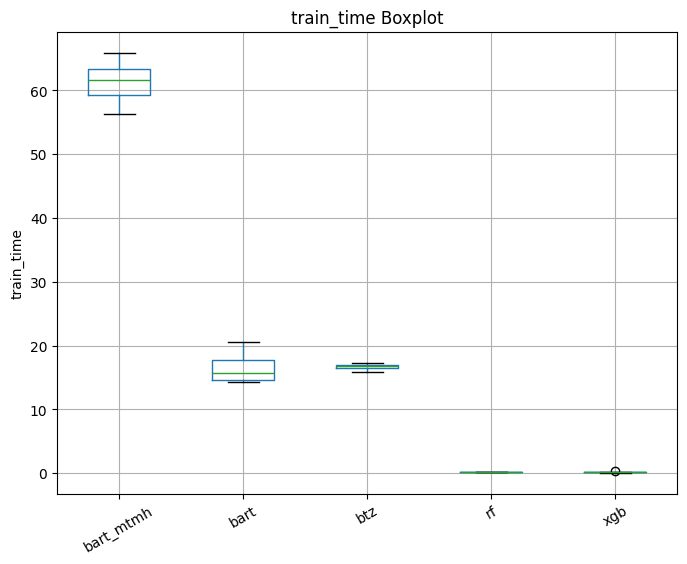

In [10]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [11]:
for k, v in mse_results.items():
    csv_name = f"results/real8_Triazines_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real8_Triazines_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50, 100],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real8_Triazines_tries.csv", index=False)

In [ ]:
print(df)